# UrbanSound8k Sound Classification



In [65]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
from pathlib import Path
import pandas as pd
import os
import matplotlib.pyplot as plt
from IPython.display import Markdown, Audio, display
import shap
import librosa.display
import seaborn as sns
import librosa
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.decomposition import PCA

from xgboost import XGBClassifier

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Load in the Dataset



In [64]:
# Folder where KaggleHub normally stores Urban Sound dataset
expected_path = (
        Path(os.path.expanduser("~"))
        / ".cache"
        / "kagglehub"
        / "datasets"
        / "chrisfilo"
        / "urbansound8k"
)

# Check if the dataset has already been downloaded
if expected_path.exists():
    path = expected_path
    path = Path(path) / "versions" / "1"
else:
    # If it doesn't exist, download
    print("Dataset not found. Downloading...\n")
    path = kagglehub.dataset_download("chrisfilo/urbansound8k")
    path = expected_path
    path = Path(path) / "versions" / "1"

# Example from the Dataset



Playing audio file:
C:\Users\julia\.cache\kagglehub\datasets\chrisfilo\urbansound8k\versions\1\fold4\344-3-5-0.wav
Sample rate: 48000 Hz


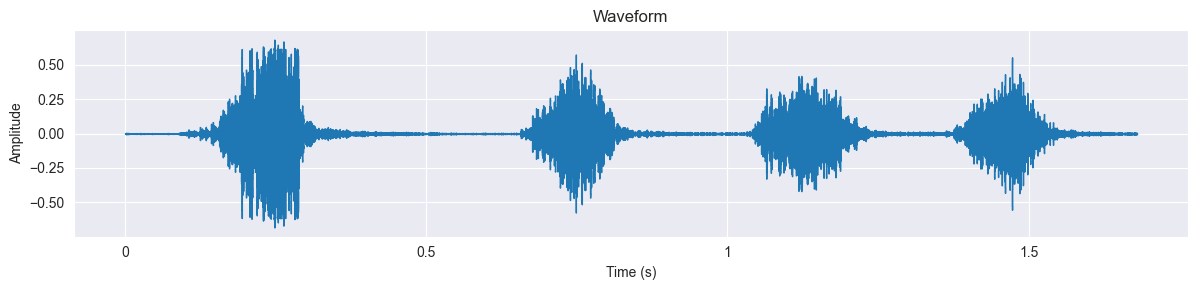

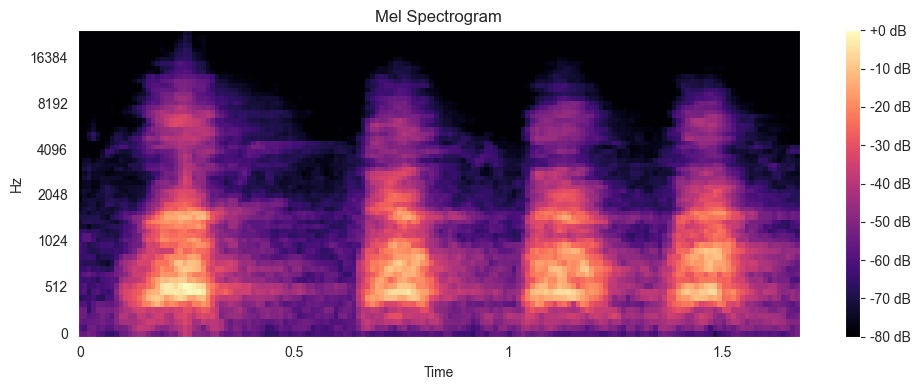

In [63]:
# Select an audio file to play

audio_file = Path(path)/ "fold4" / "344-3-5-0.wav"

# Load the audio (y = waveform, sr = sampling rate)
y, sr = librosa.load(audio_file, sr=None)   # keeps original sample rate
print(f"Playing audio file:\n{audio_file}\nSample rate: {sr} Hz")
display(Audio(y, rate=sr))

# Plot a waveform
plt.figure(figsize=(12, 3))
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

# Compute a mel spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64)
S_db = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(10, 4))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title("Mel Spectrogram")
plt.tight_layout()
plt.show()

# Dataset Summary



In [3]:
# This loads the CSV file which contains information about each audio clip
# - filename
# - classID
# - class name
metadata_path = os.path.join(path, "UrbanSound8K.csv")

# Display the first few rows in a table
meta_df = pd.read_csv(metadata_path)
print("Dataset shape (rows, columns):", meta_df.shape)
display(meta_df.head())

Dataset shape (rows, columns): (8732, 8)


,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


# Dataset Exploratory Data Analysis



### Summary Table of Sound Categories

,classID,class,count
0,0,air_conditioner,1000
1,1,car_horn,429
2,2,children_playing,1000
3,3,dog_bark,1000
4,4,drilling,1000
5,5,engine_idling,1000
6,6,gun_shot,374
7,7,jackhammer,1000
8,8,siren,929
9,9,street_music,1000


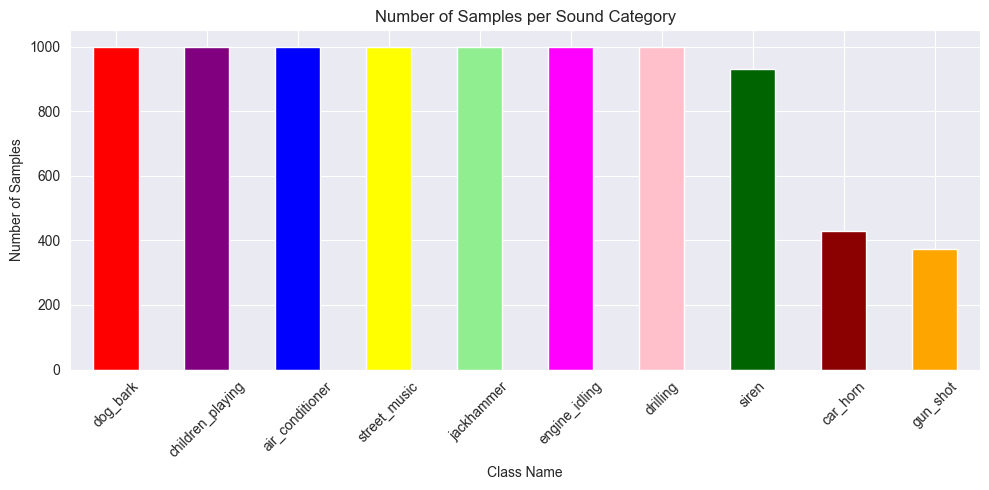

In [4]:
# Display a summary table to show the names of the classes and how many audio clips belong to each class
display(Markdown("### Summary Table of Sound Categories"))
display(
    meta_df.groupby(["classID", "class"])
      .size()
      .reset_index(name="count")
      .sort_values("classID")
      .reset_index(drop=True)
)

# Bar plot to show the distribution of the samples
plt.figure(figsize=(10,5))

meta_df["class"].value_counts().plot(
    kind="bar",
    color=["red","purple", "blue", "yellow", "lightgreen", "magenta","pink", "darkgreen", "darkred", "orange"]
)

plt.title("Number of Samples per Sound Category")
plt.xlabel("Class Name")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

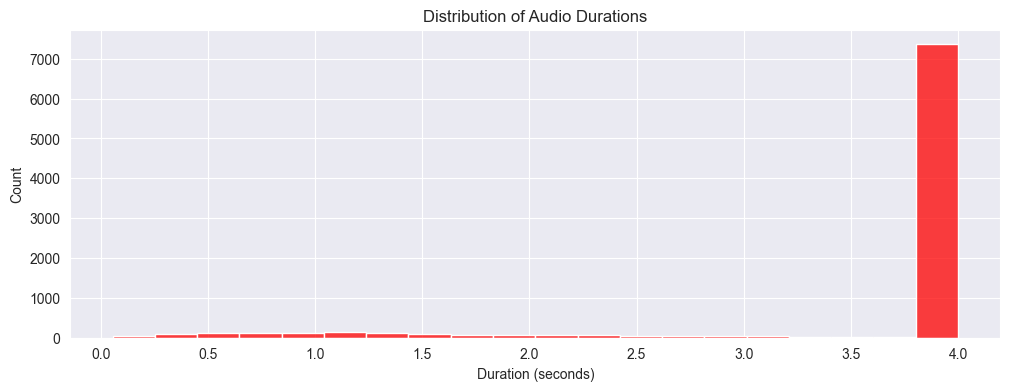

In [5]:
# Calculate the duration for each audio clip
meta_df["duration"] = meta_df["end"] - meta_df["start"]

# Plot a histogram to help understand whether the audio clips vary in time length
plt.figure(figsize=(12,4))
sns.histplot(meta_df["duration"], bins=20, color="red")
plt.title("Distribution of Audio Durations")
plt.xlabel("Duration (seconds)")
plt.show()

### Metadata Feature Correlation Matrix

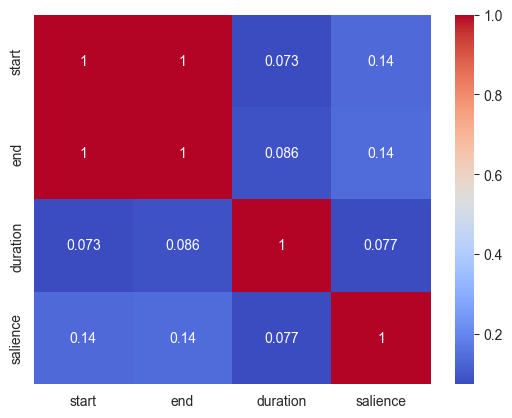

In [6]:
# Correlation heatmap to show the relationships between the features in the metadata
sns.heatmap(meta_df[["start", "end", "duration", "salience"]].corr(), annot=True, cmap="coolwarm")
display(Markdown("### Metadata Feature Correlation Matrix"))
plt.show()

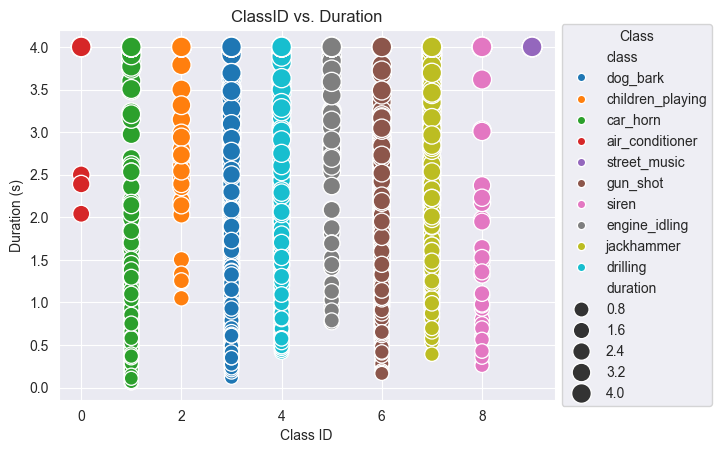

In [7]:
# Scatter plot of ClassID vs Duration
# - helps visualise whether different sound classes have clips of varying lengths
# - useful for checking dataset consistency
# - helps identify any unusual durations or potential outliers
# - colouring by class makes class patterns easier to compare visually
sns.scatterplot(
    data=meta_df,
    x="classID",
    y="duration",
    hue="class",
    size="duration",
    sizes=(100, 200)
)
plt.title("ClassID vs. Duration")
plt.xlabel("Class ID")
plt.ylabel("Duration (s)")
plt.legend(
    title="Class",
    loc="center left",
    bbox_to_anchor=(1, 0.5)
)

# Feature Extraction
- Mel-Frequency Cepstral Coefficients (MFCC): How humans perceive sound frequencies
- Chroma: Represent the intensity of the 12 pitch classes
- Spectral Contrast: Measurement between peaks and troughs


In [8]:
def extract_features(file_path):

# Extracts audio features from a single .wav file
# The final feature vector includes:
# - MFCCs (13 coefficients)
# - Chroma features (12 pitch classes)
# - Spectral contrast (7 frequency bands)

    try:
        # Load the audio file
        audio, sr = librosa.load(file_path, sr=None)

        # Extract 13 MFCC features
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
        mfccs_mean = np.mean(mfccs.T, axis=0)

        # Chroma features
        chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
        chroma_mean = np.mean(chroma.T, axis=0)

        # Spectral contrast
        contrast = librosa.feature.spectral_contrast(y=audio, sr=sr)
        contrast_mean = np.mean(contrast.T, axis=0)

        # Combine all feature groups into a final vector:
        # MFCC (13) + Chroma (12) + Contrast (7) = 32 features
        feature_vector = np.concatenate((mfccs_mean, chroma_mean, contrast_mean))

        return feature_vector

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

In [9]:
# Loop through all the audio files and extract the features and labels
features = [] # Will store feature vectors
labels = []   # Will store class IDs for each file

# Loop through all 10 folders in the UrbanSound8k folder
for fold in range(1, 11):

    # Path to current fold folder
    fold_path = os.path.join(path, f"fold{fold}")

    # Loop through every file in this folder
    for file_name in os.listdir(fold_path):
        # Only process .wav audio files
        if file_name.endswith(".wav"):
            # Full path to the audio file
            file_path = os.path.join(fold_path, file_name)
            # Extract classID
            class_label = int(file_name.split("-")[1])

            # Extract features
            feature_vector = extract_features(file_path)
            # Only keep valid files
            if feature_vector is not None:
                features.append(feature_vector)
                labels.append(class_label)

# Convert to numpy arrays
X_features = np.array(features)
y = np.array(labels)

Error processing C:\Users\julia\.cache\kagglehub\datasets\chrisfilo\urbansound8k\versions\1\fold1\155310-3-0-0.wav: Frequency band exceeds Nyquist. Reduce either fmin or n_bands.
Error processing C:\Users\julia\.cache\kagglehub\datasets\chrisfilo\urbansound8k\versions\1\fold1\40722-8-0-0.wav: Frequency band exceeds Nyquist. Reduce either fmin or n_bands.
Error processing C:\Users\julia\.cache\kagglehub\datasets\chrisfilo\urbansound8k\versions\1\fold1\40722-8-0-1.wav: Frequency band exceeds Nyquist. Reduce either fmin or n_bands.
Error processing C:\Users\julia\.cache\kagglehub\datasets\chrisfilo\urbansound8k\versions\1\fold1\40722-8-0-2.wav: Frequency band exceeds Nyquist. Reduce either fmin or n_bands.
Error processing C:\Users\julia\.cache\kagglehub\datasets\chrisfilo\urbansound8k\versions\1\fold1\40722-8-0-3.wav: Frequency band exceeds Nyquist. Reduce either fmin or n_bands.
Error processing C:\Users\julia\.cache\kagglehub\datasets\chrisfilo\urbansound8k\versions\1\fold1\40722-8-0-4

In [10]:
display(Markdown("#### Feature Extraction Results"))
# Validation from print statements to ensure the feature extraction was performed correctly
print("X_features shape:\t\t", X_features.shape)
print("y shape:\t\t\t    ", y.shape)
print("Number of samples: \t\t", len(X_features))
print("Number of labels: \t\t", len(y))
print("Unique class labels:\t", np.unique(y))
print("\nFirst feature vector:\t", X_features[0])

#### Feature Extraction Results

X_features shape:		 (8674, 32)
y shape:			     (8674,)
Number of samples: 		 8674
Number of labels: 		 8674
Unique class labels:	 [0 1 2 3 4 5 6 7 8 9]

First feature vector:	 [-422.9743042    84.81761932   28.96418953    4.29089928  -12.73487473
   -0.63045728    2.19677138   -6.97783709   -9.47678089   -5.11735249
   -6.21320343   -5.6209631     1.92232108    0.52274239    0.4666211
    0.44222698    0.4360761     0.44110009    0.46123481    0.50388724
    0.49552301    0.52213699    0.5589754     0.56968594    0.59114307
   16.2859213    11.35113189   14.69840655   15.50206316   19.36999073
   16.73811136   20.48425753]


# Split the Dataset



In [11]:
# Split dataset into a training set (70%) and a temporary (30%) set for validation and testing
X_train, X_temp, y_train, y_temp = train_test_split(
    X_features,
    y,
    test_size=0.30,        # 30% used for val + test
    random_state=42,
    stratify=y             # keeps class balance
)


# Split temporary data into Validation (15%) and Test (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.50,
    random_state=42,
    stratify=y_temp
)

print("Train:", X_train.shape)
print("Validation:", X_val.shape)
print("Test:", X_test.shape)


# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Train: (6071, 32)
Validation: (1301, 32)
Test: (1302, 32)


# Train Classic Models
- Random Forest
- XGBoost (Extreme Gradient Boosting)
- SVM RBF (Support Vector Machine with a Radial Basis Function)


In [12]:
# Define classic machine learning models
models = {
    "SVM (RBF)": SVC(
        kernel="rbf",       # Better suited for non-linear relationships
        C=10,
        gamma="scale",
        random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    ),
    "XGBoost": XGBClassifier(
        n_estimators=600,
        learning_rate=0.03,     # Slower rate
        max_depth=8,            # Depth of each tree
        subsample=0.8,          # Use 90% of the training data for each tree
        colsample_bytree=0.8,   # Use 90% of features for each tree
        objective="multi:softmax",
        num_class=10,           # number of sound classes in dataset
        random_state=42,
        n_jobs=-1,
        eval_metric="mlogloss",
        reg_alpha=0.1,          # L1 regularisation (lasso)
        reg_lambda=1.0,         # L2 regularisation (ridge)

    )
}

classic_results = {}

# Train each model and evaluate on the validation set
for name, model in models.items():

    # Train on scaled training data
    model.fit(X_train_scaled, y_train)

    # Predict on validation set
    y_val_pred = model.predict(X_val_scaled)

    # Compute metrics
    acc = accuracy_score(y_val, y_val_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_val,
        y_val_pred,
        average="macro",      # treat all classes equally
        zero_division=0
    )

    classic_results[name] = {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-score": f1
    }

# Show results in a summary table
display(Markdown("#### Validation Results of Classic Models"))
classic_results_df = pd.DataFrame(classic_results).T
display(classic_results_df)

#### Validation Results of Classic Models

,Accuracy,Precision,Recall,F1-score
SVM (RBF),0.940046,0.942550,0.939973,0.940968
Random Forest,0.901614,0.908647,0.892889,0.899512
XGBoost,0.920830,0.929181,0.913218,0.919916


# Evaluate Classic Models
- Random Forest
- XGBoost (Extreme Gradient Boosting)
- SVM RBF (Support Vector Machine with a Radial Basis Function)


In [13]:
best_model_name = classic_results_df["Accuracy"].idxmax()
display(Markdown(f"#### Best model based on accuracy score: {best_model_name}"))

best_model = models[best_model_name]

# Evaluate on the test set
y_test_pred = best_model.predict(X_test_scaled)

acc_test = accuracy_score(y_test, y_test_pred)
prec_test, rec_test, f1_test, _ = precision_recall_fscore_support(
    y_test,
    y_test_pred,
    average="macro",
    zero_division=0
)
display(Markdown(f"#### Test set performance of {best_model_name}"))
print(f"  Accuracy:\t\t {acc_test:.4f}")
print(f"  Precision:\t {prec_test:.4f}")
print(f"  Recall:\t\t {rec_test:.4f}")
print(f"  F1-score:\t\t {f1_test:.4f}")

#### Best model based on accuracy score: SVM (RBF)

#### Test set performance of SVM (RBF)

  Accuracy:		 0.9278
  Precision:	 0.9327
  Recall:		 0.9196
  F1-score:		 0.9253


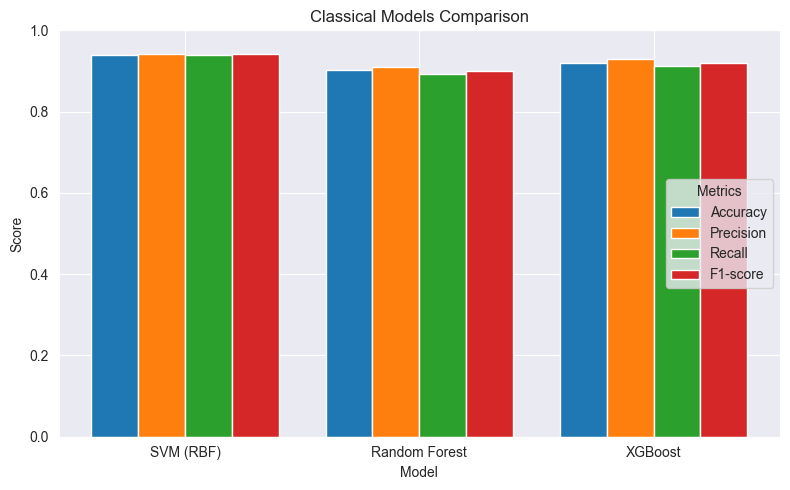

In [14]:
# Bar chart comparing multiple validation metrics for each classical model
plt.figure(figsize=(8,5))

x = np.arange(len(classic_results_df.index))  # model positions
width = 0.2

plt.bar(x - width*1.5, classic_results_df["Accuracy"], width, label="Accuracy")
plt.bar(x - width/2, classic_results_df["Precision"], width, label="Precision")
plt.bar(x + width/2, classic_results_df["Recall"], width, label="Recall")
plt.bar(x + width*1.5, classic_results_df["F1-score"], width, label="F1-score")

plt.xticks(x, classic_results_df.index)
plt.title("Classical Models Comparison")
plt.xlabel("Model")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.legend(title="Metrics",loc="center right")
plt.tight_layout()
plt.show()

# Train CNN on Spectrograms



In [15]:
# Convert feature matrix and labels into numpy arrays as floats or ints
X_features = np.array(X_features, dtype=np.float32)
y = np.array(y, dtype=int)

# Verification that the shape is what is expected
print("Original X_features:", X_features.shape)
print("Original y:\t\t\t", y.shape)

# Reshape to (N, height, width, channels) to be compatible with CNN model
X_cnn = X_features.reshape(-1, 1, 32, 1)

# Confirm output
print("After reshape:\t\t", X_cnn.shape)

Original X_features: (8674, 32)
Original y:			 (8674,)
After reshape:		 (8674, 1, 32, 1)


In [16]:
# To determine the number of classes in the dataset we could the number of unique classes and store as a constant
NUM_CLASSES = len(np.unique(labels))

# First split: 70% train and 30% temp (val + test)
X_train_cnn, X_temp_cnn, y_train_cnn, y_temp_cnn = train_test_split(
    X_cnn,
    y,
    test_size=0.30,
    stratify=y,
    random_state=42
)

# Second split: 15% val and 15% test
X_val_cnn, X_test_cnn, y_val_cnn, y_test_cnn = train_test_split(
    X_temp_cnn,
    y_temp_cnn,
    test_size=0.50,
    stratify=y_temp_cnn,
    random_state=42
)

# One-hot encode class labels into categorical format
Y_train_cnn = to_categorical(y_train_cnn, NUM_CLASSES)
Y_val_cnn  = to_categorical(y_val_cnn, NUM_CLASSES)
Y_test_cnn  = to_categorical(y_test_cnn, NUM_CLASSES)

print("X_Train:", X_train_cnn.shape)
print("X_Val:  ", X_val_cnn.shape)
print("X_Test: ", X_test_cnn.shape)
print("Y_train:", Y_train_cnn.shape)
print("Y_test: ", Y_test_cnn.shape)

X_Train: (6071, 1, 32, 1)
X_Val:   (1301, 1, 32, 1)
X_Test:  (1302, 1, 32, 1)
Y_train: (6071, 10)
Y_test:  (1302, 10)


In [17]:
# Define the input shape for the CNN
input_dim = X_train_cnn.shape[1:]   # (1, 32, 1)

# CNN model
model = Sequential()

# Conv2D with 64 filters:
# - Kernel size (1,3) slides over the 32-feature width dimension
model.add(Conv2D(64, (1, 3), padding="same", activation="tanh", input_shape=input_dim))
model.add(MaxPooling2D(pool_size=(1, 2)))   #

# Conv2D with 128 filters for deeper feature extraction
model.add(Conv2D(128, (1, 3), padding="same", activation="tanh"))
model.add(MaxPooling2D(pool_size=(1, 2)))
model.add(Dropout(0.1))

# Flatten converts the convolutional feature maps into a 1D vector
model.add(Flatten())
model.add(Dense(1024, activation="tanh"))
model.add(Dense(NUM_CLASSES, activation="softmax"))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy']
              )

model.summary()

# Train the CNN model
history = model.fit(
    X_train_cnn,
    Y_train_cnn,
    epochs=50,
    batch_size=32,
    verbose=2,
    validation_data=(X_val_cnn, Y_val_cnn)
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 1, 32, 64)      │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 1, 16, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 1, 16, 128)     │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 1, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,084,810 (4.14 MB)

 Trainable params: 1,084,810 (4.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
190/190 - 3s - 17ms/step - accuracy: 0.5714 - loss: 1.3113 - val_accuracy: 0.7194 - val_loss: 0.8770
Epoch 2/50
190/190 - 2s - 8ms/step - accuracy: 0.7150 - loss: 0.8576 - val_accuracy: 0.7594 - val_loss: 0.7733
Epoch 3/50
190/190 - 2s - 8ms/step - accuracy: 0.7645 - loss: 0.7274 - val_accuracy: 0.7417 - val_loss: 0.8176
Epoch 4/50
190/190 - 2s - 9ms/step - accuracy: 0.7887 - loss: 0.6454 - val_accuracy: 0.7855 - val_loss: 0.6708
Epoch 5/50
190/190 - 2s - 8ms/step - accuracy: 0.8111 - loss: 0.5587 - val_accuracy: 0.8017 - val_loss: 0.6279
Epoch 6/50
190/190 - 2s - 9ms/step - accuracy: 0.8333 - loss: 0.4881 - val_accuracy: 0.8155 - val_loss: 0.5728
Epoch 7/50
190/190 - 2s - 9ms/step - accuracy: 0.8499 - loss: 0.4376 - val_accuracy: 0.8255 - val_loss: 0.5924
Epoch 8/50
190/190 - 2s - 8ms/step - accuracy: 0.8712 - loss: 0.3797 - val_accuracy: 0.8524 - val_loss: 0.4935
Epoch 9/50
190/190 - 2s - 8ms/step - accuracy: 0.8811 - loss: 0.3533 - val_accuracy: 0.8609 - val_loss: 0.4808


In [18]:
# Display evaluation metrics
test_loss, test_acc = model.evaluate(X_test_cnn, Y_test_cnn, verbose=0)
print(f"Test loss: \t\t{test_loss:.4f}")
print(f"Test accuracy:  {test_acc:.4f}")

# Convert one-hot encoded labels into integer labels
y_true = np.argmax(Y_test_cnn, axis=1)

# Predict class probabilities, then convert into integer labels
y_pred_probs = model.predict(X_test_cnn, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification Report (Precision, Recall, F1 per class)
print("\n--- CLASSIFICATION REPORT (CNN - Test Set) ---")
print(classification_report(y_true, y_pred, digits=4))

Test loss: 		0.4658
Test accuracy:  0.9171

--- CLASSIFICATION REPORT (CNN - Test Set) ---
              precision    recall  f1-score   support

           0     0.9860    0.9400    0.9625       150
           1     0.9298    0.8281    0.8760        64
           2     0.8476    0.9392    0.8910       148
           3     0.9328    0.8503    0.8897       147
           4     0.8239    0.9667    0.8896       150
           5     0.9172    0.9600    0.9381       150
           6     0.9434    0.8929    0.9174        56
           7     0.9730    0.9600    0.9664       150
           8     0.9776    0.9493    0.9632       138
           9     0.8971    0.8188    0.8561       149

    accuracy                         0.9171      1302
   macro avg     0.9228    0.9105    0.9150      1302
weighted avg     0.9205    0.9171    0.9171      1302



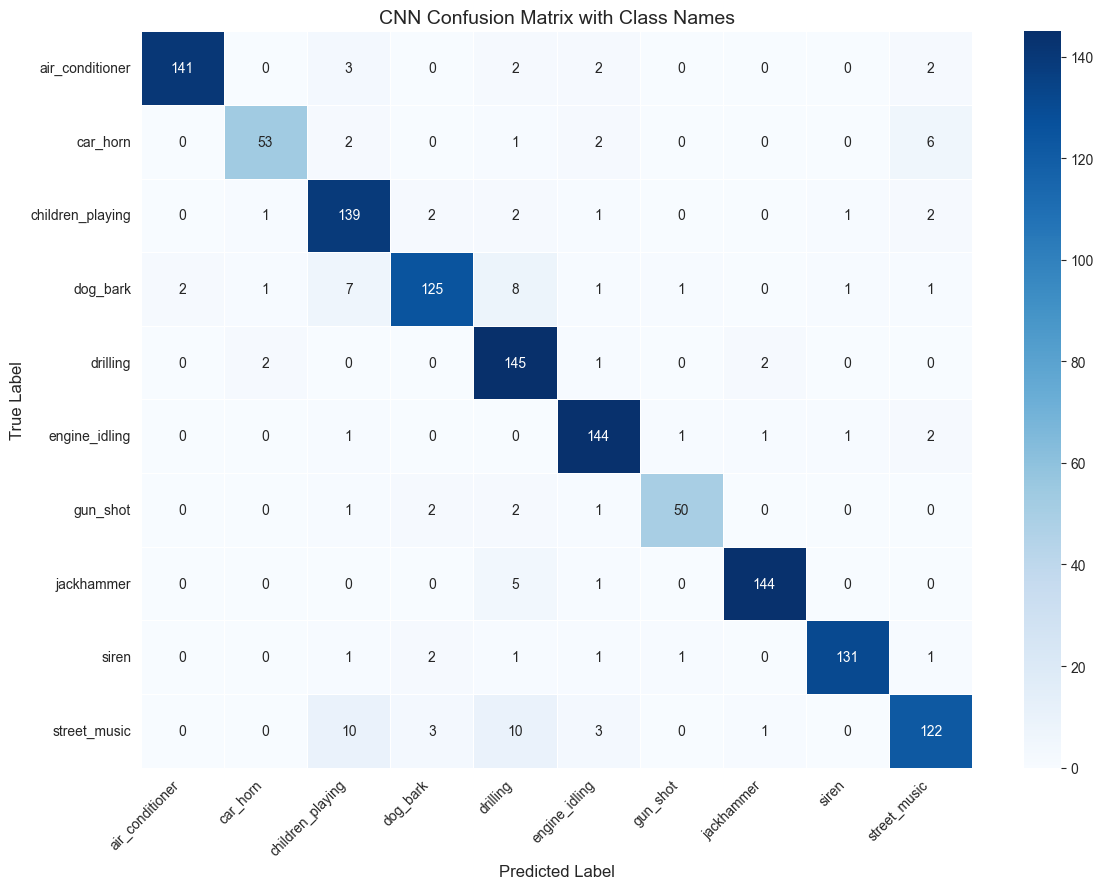

In [19]:
# Class names in the correct UrbanSound8K order
class_names = [
    "air_conditioner",
    "car_horn",
    "children_playing",
    "dog_bark",
    "drilling",
    "engine_idling",
    "gun_shot",
    "jackhammer",
    "siren",
    "street_music"
]

# Convert one-hot into class IDs
y_true = np.argmax(Y_test_cnn, axis=1)
y_pred = np.argmax(model.predict(X_test_cnn, verbose=0), axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 9))

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
    linewidths=0.5,
    linecolor="white"
)

plt.title("CNN Confusion Matrix with Class Names", fontsize=14)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Model Comparison Between CNN vs Classic Models



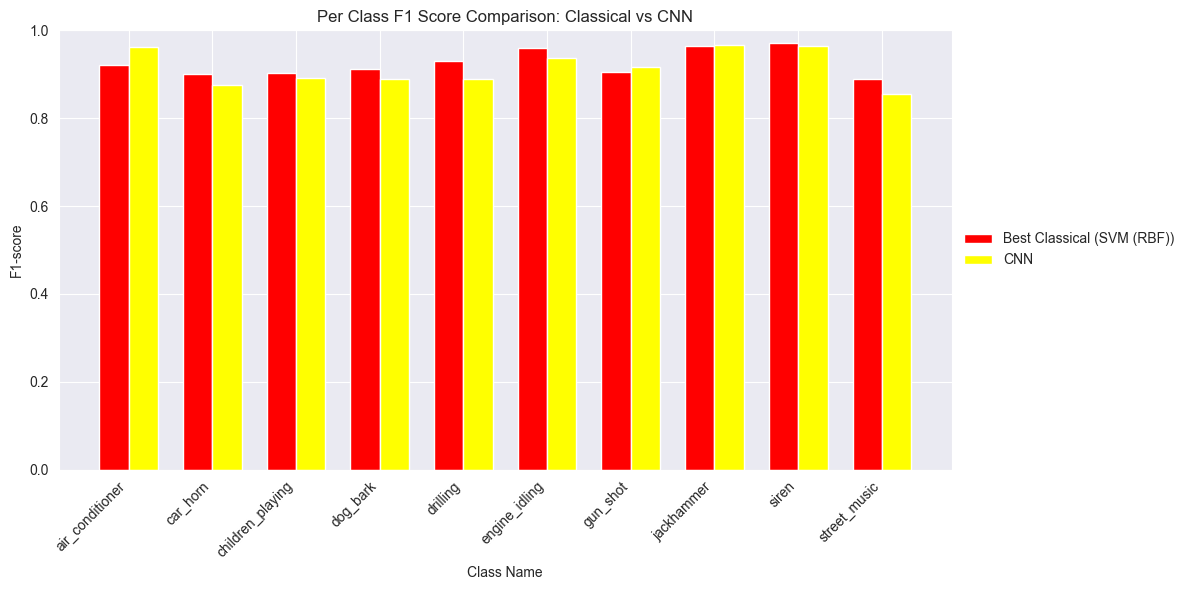

In [23]:
# Function to extract each class' metrics
def per_class_metrics(y_true, y_pred):
    prec, rec, f1, support = precision_recall_fscore_support(
        y_true,
        y_pred,
        average=None,
        zero_division=0
    )
    return pd.DataFrame({
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "support": support
    })
# Get the best classic model
best_model = models[best_model_name]

#
y_test_pred_classic = best_model.predict(X_test_scaled)

# CNN metrics
cnn_df = per_class_metrics(y_true, y_pred).add_prefix("cnn_")

# Classic model metrics
classic_df = per_class_metrics(y_test, y_test_pred).add_prefix("classic_")

# Combine table
per_class_compare = pd.concat([cnn_df, classic_df], axis=1)

# Add class IDs
per_class_compare["class_id"] = per_class_compare.index

# Extract class names from the metadata
class_mapping = dict(zip(meta_df["classID"], meta_df["class"]))
per_class_compare["class_name"] = per_class_compare["class_id"].map(class_mapping)

# Plot results on a bar chart
plt.figure(figsize=(12, 6))

x = np.arange(len(per_class_compare))   # positions for bars
width = 0.35

plt.bar(
    x - width/2,
    per_class_compare["classic_f1"],
    width,
    label=f"Best Classical ({best_model_name})",
    color="red"
)

plt.bar(
    x + width/2,
    per_class_compare["cnn_f1"],
    width,
    label="CNN",
    color="yellow"
)

# Use class names on the x-axis
plt.xticks(x, per_class_compare["class_name"], rotation=45, ha="right")
plt.xlabel("Class Name")
plt.ylabel("F1-score")
plt.title("Per Class F1 Score Comparison: Classical vs CNN")
plt.ylim(0, 1)
plt.legend(
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    frameon=False
)
plt.tight_layout()
plt.show()

In [24]:
# Identification of the easiest and hardest classes for the cnn model to predict

sorted_df = per_class_compare.sort_values("cnn_f1", ascending=False)

top2 = sorted_df.head(2)
bottom2 = sorted_df.tail(2)

display(Markdown("#### Comparison Between Easiest vs Hardest Classes to Predict"))
print("Top 2 easiest classes to predict:")
for _, row in top2.iterrows():
    print(f" {row['class_name']} (F1 = {row['cnn_f1']:.4f})")

print("\nBottom 2 hardest classes to predict:")
for _, row in bottom2.iterrows():
    print(f" {row['class_name']} (F1 = {row['cnn_f1']:.4f})")



# Average scores for both models

avg_svm_f1 = per_class_compare["classic_f1"].mean()
avg_cnn_f1 = per_class_compare["cnn_f1"].mean()

display(Markdown("#### Comparison Between CNN vs SVM (RBF) Scores"))
print(f"SVM (RBF) Test Accuracy:\t\t {acc_test:.4f}")
print(f"SVM (RBF) Average F1:\t\t\t {avg_svm_f1:.4f}")
print(f"\nCNN Model Test Accuracy: \t\t {test_acc:.4f}")
print(f"CNN Model Average F1:            {avg_cnn_f1:.4f}")

#### Comparison Between Easiest vs Hardest Classes to Predict

Top 2 easiest classes to predict:
 jackhammer (F1 = 0.9664)
 siren (F1 = 0.9632)

Bottom 2 hardest classes to predict:
 car_horn (F1 = 0.8760)
 street_music (F1 = 0.8561)


#### Comparison Between CNN vs SVM (RBF) Scores

SVM (RBF) Test Accuracy:		 0.9278
SVM (RBF) Average F1:			 0.9253

CNN Model Test Accuracy: 		 0.9171
CNN Model Average F1:            0.9150


# SHAP (SHapley Additive exPlanations)
- to evaluate each feature's contribution to the outcome of the model




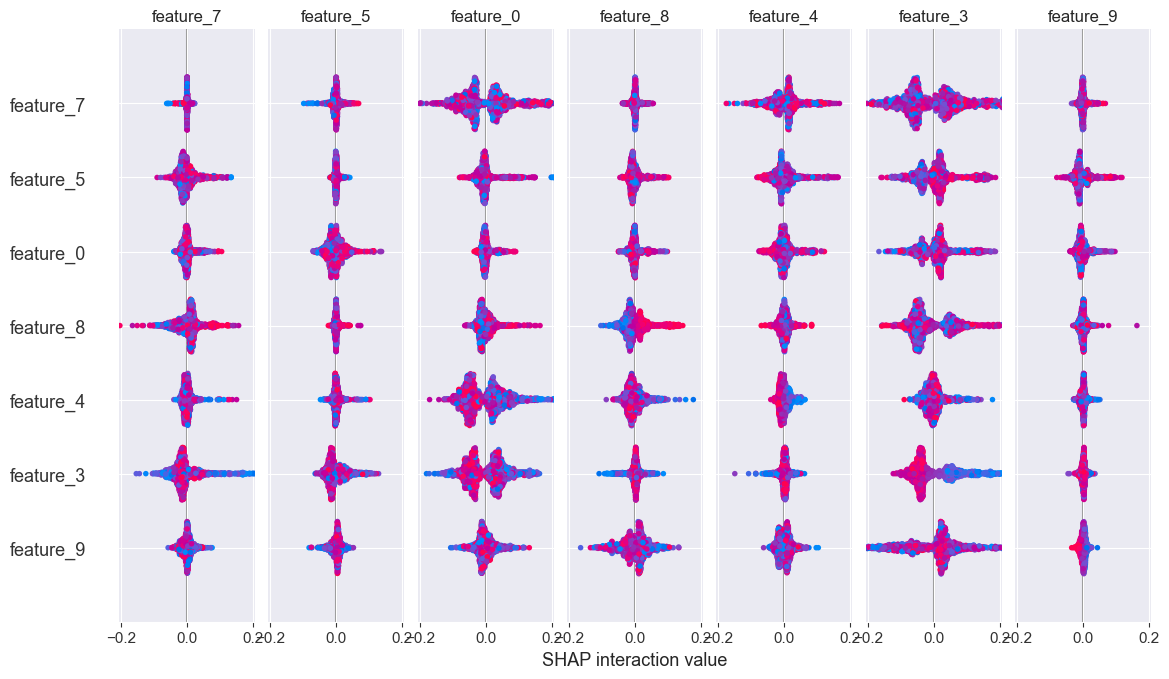

In [75]:
# Define the feature names
feature_names= [f"feature_{i}" for i in range(X_train_scaled.shape[1])]

# I selected the tree model Random Forest
tree_model_name = "Random Forest"
tree_model = models[tree_model_name]

# Refit model
tree_model.fit(X_train_scaled, y_train)

# Use test data to understand feature contributions
X_shap = X_test_scaled

# Create a tree explainer
explainer = shap.TreeExplainer(tree_model)
shap_values = explainer.shap_values(X_shap)

# SHAP for one class, which can be changed to inspect other classes
class_id = 0

sv_class = shap_values[class_id]
if isinstance(shap_values, list):
    sv_class = shap_values[class_id]
else:
    sv_class = shap_values

shap.summary_plot(
    sv_class,
    X_shap,
    feature_names=feature_names,
    show=True
)

# Feature Importance
- to evaluate each feature's contribution to the outcome of the model




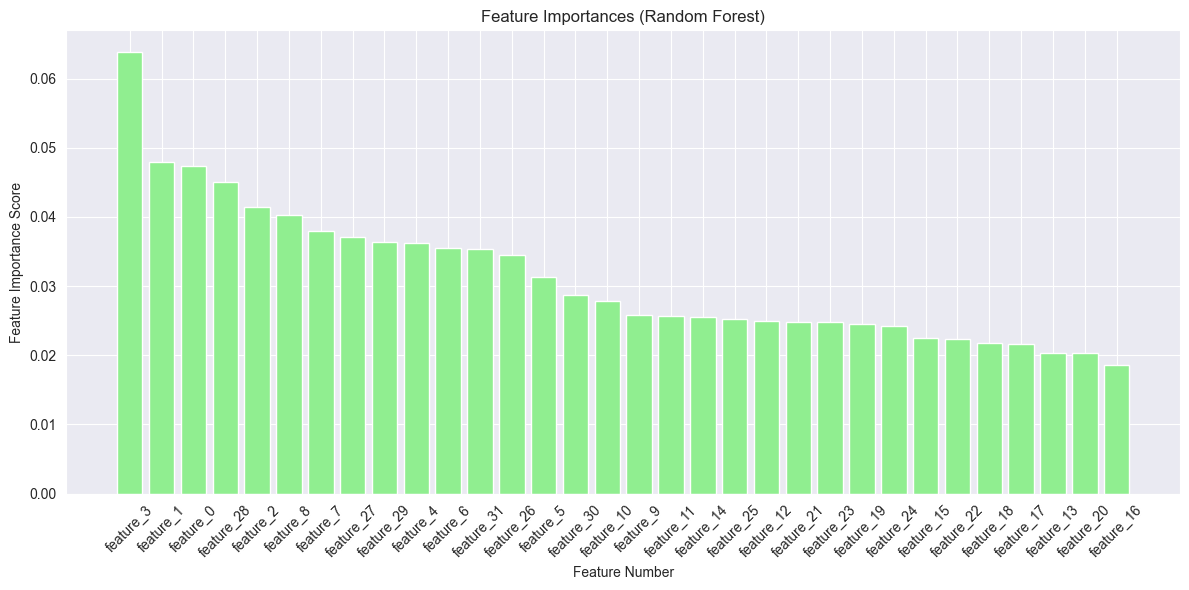

The first 13 features belong to MFCC [0..12], then the next 12 to Chroma [13..25], and further the next 7 Spectral contrast [26..32]


In [104]:
# Select the tree model
tree_model = models["Random Forest"]

# Make sure the model is fitted
tree_model.fit(X_train_scaled, y_train)

# Extract feature importances
importances = tree_model.feature_importances_

# Sort for better plotting
indices = np.argsort(importances)[::-1]  # descending order

plt.figure(figsize=(12, 6))
plt.bar(range(len(importances)), importances[indices], color="lightgreen")
plt.xticks(range(len(importances)), np.array(feature_names)[indices], rotation=45)
plt.ylabel("Feature Importance Score")
plt.xlabel("Feature Number")
plt.title("Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()
print("The first 13 features belong to MFCC [0..12], then the next 12 to Chroma [13..25], and further the next 7 Spectral contrast [26..32]")

# K-Means Clustering on MFCCs




ARI : 0.1009
NMI : 0.1888


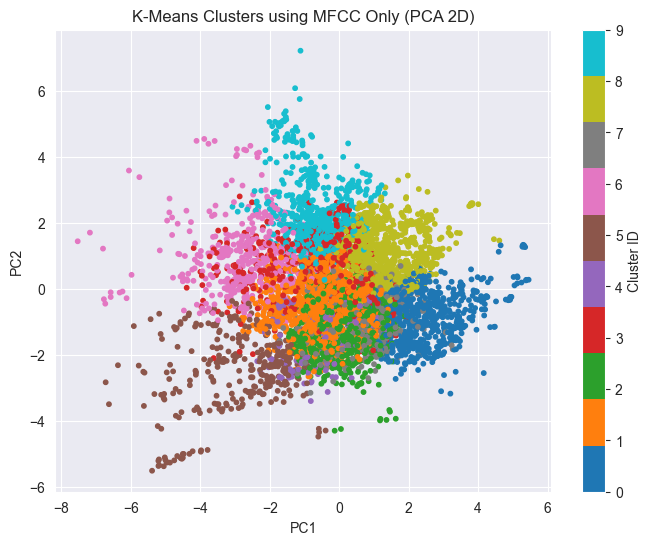

In [92]:
# Only use MFCC features for clustering (first 13 features)
num_mfcc = 13
X_train_mfcc = X_train_scaled[:, :num_mfcc]

kmeans = KMeans(
    n_clusters=len(np.unique(y_train)), # Number of classes
    random_state=42,
    n_init=10
)

kmeans_labels = kmeans.fit_predict(X_train_mfcc)

# Adjusted Rand Index and Normalised Mutual Information
ari = adjusted_rand_score(y_train, kmeans_labels)
nmi = normalized_mutual_info_score(y_train, kmeans_labels)

print(f"ARI : {ari:.4f}")
print(f"NMI : {nmi:.4f}")

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_mfcc)

plt.figure(figsize=(8,6))
plt.scatter(
    X_pca[:,0], X_pca[:,1],
    c=kmeans_labels,
    cmap="tab10",
    s=10
)
plt.title("K-Means Clusters using MFCC Only (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster ID")
plt.show()

### Confusion Matrix (True Class vs Cluster IDs)

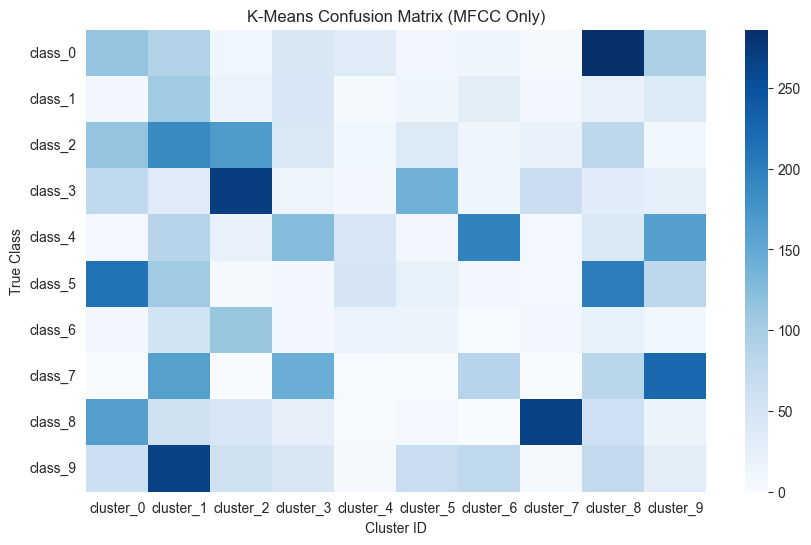

In [99]:
# Create a confusion matrix
cm = confusion_matrix(y_train, kmeans_labels)

# Create a labelled dataframe
df_cm = pd.DataFrame(
    cm,
    index=[f"class_{i}" for i in sorted(np.unique(y_train))],
    columns=[f"cluster_{i}" for i in sorted(np.unique(kmeans_labels))]
)

display(Markdown("### Confusion Matrix (True Class vs Cluster IDs)"))

plt.figure(figsize=(10, 6))
sns.heatmap(df_cm, annot=False, cmap="Blues")
plt.title("K-Means Confusion Matrix (MFCC Only)")
plt.xlabel("Cluster ID")
plt.ylabel("True Class")
plt.show()

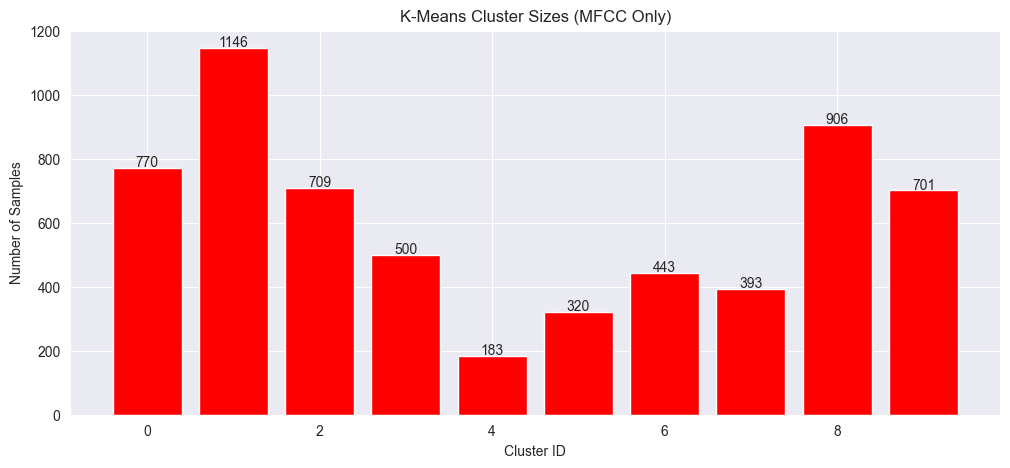

In [102]:
# Bar plot of cluster counts

# Count how many samples are in each cluster
cluster_ids, counts = np.unique(kmeans_labels, return_counts=True)

plt.figure(figsize=(12, 5))
plt.bar(cluster_ids, counts, color="red")
plt.title("K-Means Cluster Sizes (MFCC Only)")
plt.xlabel("Cluster ID")
plt.ylabel("Number of Samples")

# Add numbers on top of each bar
for i, count in zip(cluster_ids, counts):
    plt.text(i, count + 5, str(count), ha='center')
plt.show()

# Summary
#### Extract Features
For the classic machine learning models, I extracted 32 audio features in total. These consisted of 13 MFCC coefficients, 12 chroma features, and 7 spectral contrast values. MFCC are widely used because they imitate how humans perceive human frequencies. Chroma features represent pitch information which would be useful for musical sounds, and spectral contrast measures the difference between the peaks and troughs in the spectrum. Based on the extracted features, we would anticipate that audio with consistent spectral contrast vectors and stable pitch distributions would be easier for the classifier to recognise. During the exploratory data analysis I also identified that the category "car horn" and "gun shot" were underrepresented within the dataset which could potentially make it harder for models to categorise them.
#### Train Machine Learning Models
Three machine learning models were trained and analysed (SVM, Random Forest, and  XGBoost). SVM and XGBoost outperformed Random Forest, which may be due to their ability to capture nonlinearities more effectively. Although, each model performed close to or over 90% which is a good result.
#### Train CNN on Spectrograms
The CNN model achieved the highest accuracy and F1-score, which is expected because CNNs can learn deeper hierarchical patterns from spectrograms, effectively modelling shapes, textures, and temporal–frequency transitions that are difficult for traditional machine learning models to capture.
#### Compare Models
The F1 scores from the SVM and CNN models were compared to understand which classes were easier or harder to classify. The two easiest classes to predict were jackhammer and siren. This makes sense because both sounds have distinctive spectral characteristics, sirens have strong, high-frequency harmonics, while jackhammers produce repetitive, high-energy noise, making them relatively easy for the models to identify. The two most difficult classes were car horn and street music. These sounds are more challenging due to variability and background interference, car horns often occur alongside traffic noise, and street music can include mixed instruments, voices, and environmental sounds. As a result, their spectral patterns overlap more with other classes, reducing model performance.
#### Feature Importance Analysis
Both SHAP and Random Forest importance scores showed that MFCCs dominated the model’s decisions. Because MFCCs represent the core spectral shape of a sound, they naturally carried more weight than chroma or spectral contrast, which played only minor roles in distinguishing the audio classes. Specific features were highlighted as being the most influential within the decision-making, which could represent certain harmonics which are useful to detect certain sounds. 
#### K-Means Clustering
K-Means was applied using MFCC features only. The ARI and NMI scores were low, and the clusters were highly imbalanced, showing little alignment with true sound classes. PCA visualisation and the confusion matrix confirmed that MFCC space does not form meaningful natural clusters. This reinforces that supervised learning is far more effective for classifying the sound dataset than unsupervised clustering.
